In [46]:
import os
import json
import time
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy.sparse import hstack
import string
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
import xgboost as xgb

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
seed = 291

In [3]:
data_dir = "../data/runtime"
data = pd.read_csv(os.path.join(data_dir, "proccessed-data.csv"))
data.head()

,query,runtime (ms),query_complexity,runtime_boolean,table_size,length
0,select distinct coursealias0advisory_requireme...,8.092165,1,1,11453,15
1,select distinct coursealias0department coursea...,0.772238,1,0,11531,34
2,select distinct coursealias0department coursea...,0.530958,1,0,11531,36
3,select count 0 from course as coursealias0 cou...,92.988014,0,1,326457,53
4,select distinct coursealias0department coursea...,1.093864,1,0,23060,56


In [4]:
labels = data['runtime_boolean']

In [5]:
x_basic = data[['query_complexity', 'table_size', 'length']].copy().values

## BoW (CountVectorizer)

In [6]:
bow_features = data['query'].copy()
vectorizer = CountVectorizer()
bow_features = vectorizer.fit_transform(bow_features)
additional_features = data[['query_complexity', 'table_size', 'length']].values
x_bow = hstack([bow_features, additional_features])
x_bow = x_bow.toarray()
print(x_bow.shape)

(1799, 1440)


## Word2Vec

In [7]:
w2v_features = data['query'].apply(lambda x: x.lower().split())
translator = str.maketrans('', '', string.punctuation)
w2v_features = [[word for word in query if word.translate(translator) != ''] for query in w2v_features]

In [8]:
word2vec_model = Word2Vec(w2v_features, window=5, min_count=1, workers=4)

In [9]:
word_embeddings = {word: word2vec_model.wv[word] for word in word2vec_model.wv.key_to_index.keys()}
w2v_mean_features = np.array([np.mean([word_embeddings[word] for word in query], axis=0) for query in w2v_features])
x_w2v = np.hstack([w2v_mean_features, additional_features])
print(x_w2v.shape)

(1799, 103)


In [10]:
def get_split_indices(n_sample, test_size=0.15, valid_size=0.15, random_state=seed):
    indices = np.arange(n_sample)
    valid_perc = valid_size / (1. - test_size)
    
    train_val_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=random_state)
    train_indices, val_indices = train_test_split(train_val_indices, test_size=valid_perc, random_state=random_state)  #
    return train_val_indices, train_indices, val_indices, test_indices

In [11]:
train_val_indices, train_indices, val_indices, test_indices = get_split_indices(x_basic.shape[0])
print(len(train_val_indices), len(train_indices), len(val_indices), len(test_indices))

1529 1259 270 270


In [12]:
# train, validation, test split (70:15:15)
basic_X_train, basic_y_train = x_basic[train_indices].copy(), labels[train_indices]
basic_X_val, basic_y_val = x_basic[val_indices].copy(), labels[val_indices]
basic_X_test, basic_y_test = x_basic[test_indices].copy(), labels[test_indices]
basic_X_trainval, basic_y_trainval = x_basic[train_val_indices].copy(), labels[train_val_indices]

bow_X_train, bow_y_train = x_bow[train_indices].copy(), labels[train_indices]
bow_X_val, bow_y_val = x_bow[val_indices].copy(), labels[val_indices]
bow_X_test, bow_y_test = x_bow[test_indices].copy(), labels[test_indices]
bow_X_trainval, bow_y_trainval = x_bow[train_val_indices].copy(), labels[train_val_indices]

w2v_X_train, w2v_y_train = x_w2v[train_indices].copy(), labels[train_indices]
w2v_X_val, w2v_y_val = x_w2v[val_indices].copy(), labels[val_indices]
w2v_X_test, w2v_y_test = x_w2v[test_indices].copy(), labels[test_indices]
w2v_X_trainval, w2v_y_trainval = x_w2v[train_val_indices].copy(), labels[train_val_indices]

In [13]:
# normalize trainval data
basic_trainval_scaler = MinMaxScaler()
norm_basic_X_trainval = basic_trainval_scaler.fit_transform(basic_X_trainval)
norm_basic_X_test = basic_trainval_scaler.fit_transform(basic_X_test)

bow_trainval_scaler = MinMaxScaler()
norm_bow_X_trainval = bow_trainval_scaler.fit_transform(bow_X_trainval)
norm_bow_X_test = bow_trainval_scaler.fit_transform(bow_X_test)

w2v_trainval_scaler = MinMaxScaler()
norm_w2v_X_trainval = w2v_trainval_scaler.fit_transform(w2v_X_trainval)
norm_w2v_X_test = w2v_trainval_scaler.fit_transform(w2v_X_test)

In [14]:
# Suppress warnings (Some convergence warning in SVC and MLP)
import warnings
warnings.filterwarnings("ignore")
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

## SVM

In [17]:
svc_params = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

In [18]:
svc = SVC(max_iter=5000)
basic_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_svc_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_svc_clf.best_estimator_)
print(basic_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=1000, degree=2, max_iter=5000)
0.8417122040072862


In [19]:
svc = SVC()
bow_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_svc_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_svc_clf.best_estimator_)
print(bow_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=10, degree=2)
0.8901082181506483


In [20]:
svc = SVC()
w2v_svc_clf = GridSearchCV(estimator=svc, param_grid=svc_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_svc_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_svc_clf.best_estimator_)
print(w2v_svc_clf.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
SVC(C=10, degree=4, kernel='poly')
0.882252223293689


## Random Forest

In [21]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

In [22]:
rf = RandomForestClassifier()
basic_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_rf_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_rf_clf.best_estimator_)
print(basic_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=5)
0.8881452909032467


In [24]:
rf = RandomForestClassifier()
bow_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_rf_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_rf_clf.best_estimator_)
print(bow_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
0.8874916961320046


In [25]:
rf = RandomForestClassifier()
w2v_rf_clf = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_rf_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_rf_clf.best_estimator_)
print(w2v_rf_clf.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
0.8888096003428695


## XGBoost

In [26]:
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [27]:
xgbc = xgb.XGBClassifier()
basic_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_xgb_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_xgb_clf.best_estimator_)
print(basic_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8894503375120539


In [28]:
xgbc = xgb.XGBClassifier()
bow_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_xgb_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_xgb_clf.best_estimator_)
print(bow_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.9031951141112182


In [29]:
xgbc = xgb.XGBClassifier()
w2v_xgb_clf = GridSearchCV(estimator=xgbc, param_grid=xgb_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_xgb_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_xgb_clf.best_estimator_)
print(w2v_xgb_clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
0.8927333119039964


## MLP

In [31]:
mlp_params = {
    'hidden_layer_sizes': [(50, 50), (100,), (100, 50, 25)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [400, 600],
    'batch_size': [64]
}

In [32]:
mlp = MLPClassifier(random_state=291)
basic_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
basic_mlp_clf.fit(norm_basic_X_trainval, basic_y_trainval)
print(basic_mlp_clf.best_estimator_)
print(basic_mlp_clf.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
MLPClassifier(alpha=0.001, batch_size=64, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=400, random_state=291)
0.8456423443694419


In [34]:
mlp = MLPClassifier(random_state=291)
bow_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
bow_mlp_clf.fit(norm_bow_X_trainval, bow_y_trainval)
print(bow_mlp_clf.best_estimator_)
print(bow_mlp_clf.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
MLPClassifier(alpha=0.01, batch_size=64, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=400, random_state=291,
              solver='sgd')
0.8848666023786563


In [35]:
mlp = MLPClassifier(random_state=291)
w2v_mlp_clf = GridSearchCV(estimator=mlp, param_grid=mlp_params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
w2v_mlp_clf.fit(norm_w2v_X_trainval, w2v_y_trainval)
print(w2v_mlp_clf.best_estimator_)
print(w2v_mlp_clf.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
MLPClassifier(activation='tanh', alpha=0.001, batch_size=64,
              hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.1, max_iter=400, random_state=291,
              solver='sgd')
0.8548033858352084


## Evaluate on Test Set

In [37]:
def evaluate(test_X, test_y, model, output_dict=True):
    y_pred = model.predict(test_X)
    report = classification_report(test_y, y_pred, output_dict=output_dict)
    return model, report

In [38]:
# SVM
_, basic_svc_res = evaluate(norm_basic_X_test, basic_y_test, basic_svc_clf.best_estimator_)
print('SVC Basic')
print(basic_svc_res['accuracy'])

_, bow_svc_res = evaluate(norm_bow_X_test, bow_y_test, bow_svc_clf.best_estimator_)
print('SVC BOW')
print(bow_svc_res['accuracy'])

_, w2v_svc_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_svc_clf.best_estimator_)
print('SVC W2V')
print(w2v_svc_res['accuracy'])

SVC Basic
0.8592592592592593
SVC BOW
0.9111111111111111
SVC W2V
0.5555555555555556


In [39]:
# RF
_, basic_rf_res = evaluate(norm_basic_X_test, basic_y_test, basic_rf_clf.best_estimator_)
print('RF Basic')
print(basic_rf_res['accuracy'])

_, bow_rf_res = evaluate(norm_bow_X_test, bow_y_test, bow_rf_clf.best_estimator_)
print('RF BOW')
print(bow_rf_res['accuracy'])

_, w2v_rf_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_rf_clf.best_estimator_)
print('RF W2V')
print(w2v_rf_res['accuracy'])

RF Basic
0.7814814814814814
RF BOW
0.8962962962962963
RF W2V
0.8444444444444444


In [40]:
# XGB
_, basic_xgb_res = evaluate(norm_basic_X_test, basic_y_test, basic_xgb_clf.best_estimator_)
print('XGB Basic')
print(basic_xgb_res['accuracy'])

_, bow_xgb_res = evaluate(norm_bow_X_test, bow_y_test, bow_xgb_clf.best_estimator_)
print('XGB BOW')
print(bow_xgb_res['accuracy'])

_, w2v_xgb_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_xgb_clf.best_estimator_)
print('XGB W2V')
print(w2v_xgb_res['accuracy'])

XGB Basic
0.837037037037037
XGB BOW
0.8925925925925926
XGB W2V
0.8148148148148148


In [41]:
# MLP
_, basic_mlp_res = evaluate(norm_basic_X_test, basic_y_test, basic_mlp_clf.best_estimator_)
print('MLP Basic')
print(basic_mlp_res['accuracy'])

_, bow_mlp_res = evaluate(norm_bow_X_test, bow_y_test, bow_mlp_clf.best_estimator_)
print('MLP BOW')
print(bow_mlp_res['accuracy'])

_, w2v_mlp_res = evaluate(norm_w2v_X_test, w2v_y_test, w2v_mlp_clf.best_estimator_)
print('MLP W2V')
print(w2v_mlp_res['accuracy'])

MLP Basic
0.837037037037037
MLP BOW
0.8814814814814815
MLP W2V
0.8074074074074075


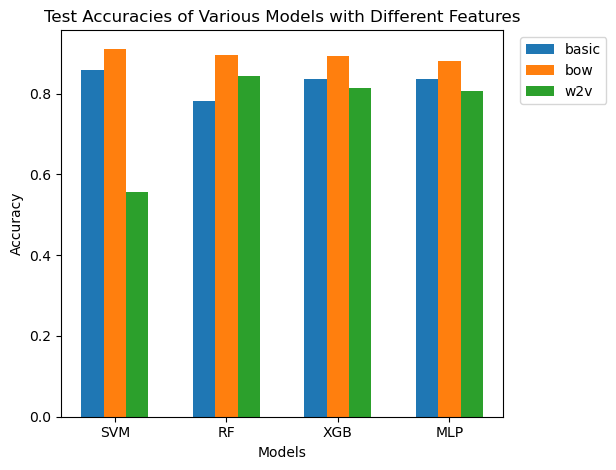

In [42]:
# Plot Results
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_accuracy = [
    [0.8592592592592593, 0.9111111111111111, 0.5555555555555556],  # Accuracies for SVC
    [0.7814814814814814, 0.8962962962962963, 0.8444444444444444],  # Accuracies for RF
    [0.837037037037037, 0.8925925925925926, 0.8148148148148148],   # Accuracies for XGB
    [0.837037037037037, 0.8814814814814815, 0.8074074074074075]   # Accuracies for MLP
]

n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [acc[i] for acc in all_accuracy], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracies of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_accuracies.png')

plt.show()

In [43]:
# Most important features given by RF
rf_bow_feature_importance = bow_rf_clf.best_estimator_.feature_importances_
sorted_feature_importance = np.argsort(-np.abs(rf_bow_feature_importance))
bow_full_feature_names = np.concatenate((vectorizer.get_feature_names_out(), ['query_complexity', 'table_size', 'length']))
k = 20
print(f'Top {k} most important features')
print(bow_full_feature_names[sorted_feature_importance[:k]])

Top 20 most important features
['table_size' 'length' 'and' 'movie' 'as' 'moviealias0' 'actoralias0'
 'actoralias0name' 'coursealias0course_id'
 'course_offeringalias0course_id' 'moviealias0mid'
 'program_coursealias0course_id' 'fare_basisalias1basis_days'
 'airport_service' 'actor' 'course' 'course_offeringalias0' 'coursealias0'
 'coursealias0number' 'directoralias0name']


In [ ]:
# Test on Yelp Dataset

In [ ]:
yelp = pd.read_csv(os.path.join(data_dir, 'query-runtime-yelp.csv'))
yelp.head()

In [ ]:
yelp['query'] = yelp['query'].str.lower()
complex_keywords = ["join", "distinct", "group by", "count", "order by"]

def check_query_complexity(query):
    words = query.split()
    return int(any(keyword in words for keyword in complex_keywords))

yelp["query_complexity"] = yelp["query"].apply(check_query_complexity)

threshold = 2.7047347051217843
yelp['runtime_boolean'] = (yelp['runtime (ms)'] >= threshold).astype(int)
counts = yelp['runtime_boolean'].value_counts()
print(counts)

In [ ]:
with open("../data/table_sizes.json", 'r') as json_file:
    table_names = json.load(json_file)

In [ ]:
def compute_table_size(row, table_names):
    query = row['query']
    db = row['db']
    words = query.split()
    count = 0
    for word in words:
        if word in table_names[db]:
            count += table_names[db][word]
    return count

yelp['table_size'] = yelp.apply(lambda row: compute_table_size(row, table_names), axis=1)

In [ ]:
del yelp['engine']
del yelp['db']

In [ ]:
yelp_x_basic = yelp[['query_complexity', 'table_size']].copy()

yelp_bow_features = vectorizer.transform(yelp['query'].copy())
yelp_additional_features = yelp[['query_complexity', 'table_size']].values
yelp_x_bow = hstack([yelp_bow_features, yelp_additional_features])
print(yelp_x_bow.shape)

In [ ]:
yelp_labels = yelp['runtime_boolean']

In [ ]:
# Nomalize using the original scaler
yelp_norm_basic_X = basic_trainval_scaler.transform(yelp_x_basic)
yelp_norm_bow_X = bow_trainval_scaler.transform(yelp_x_bow.toarray())

In [ ]:
_, yelp_basic_res = evaluate(yelp_norm_basic_X, yelp_labels, basic_rf_clf.best_estimator_)
print('Yelp RF Basic')
print(yelp_basic_res['accuracy'])

_, yelp_bow_res = evaluate(yelp_norm_bow_X, yelp_labels, bow_rf_clf.best_estimator_)
print('Yelp RF BOW')
print(yelp_bow_res['accuracy'])

In [47]:
# Should turn the train, eval, and get time task to a reusable function
# Keeping the runtime fo training and evaluating each model
train_time_data = defaultdict(list)
pred_time_data = defaultdict(list)

# SVC
basic_svc = SVC(C=1000, degree=2, max_iter=5000)
s = time.time()
basic_svc = basic_svc.fit(norm_basic_X_trainval, basic_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['svc'].append(elapsed)

bow_svc = SVC(C=10, degree=2)
s = time.time()
bow_svc = bow_svc.fit(norm_bow_X_trainval, bow_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['svc'].append(elapsed)

w2v_svc = SVC(C=10, degree=4, kernel='poly')
s = time.time()
w2v_svc = w2v_svc.fit(norm_w2v_X_trainval, w2v_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['svc'].append(elapsed)

s = time.time()
_, basic_svc_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_svc)
e = time.time()
elapsed = e - s
pred_time_data['svc'].append(elapsed)
print('SVC Basic')
print('f1 score:', basic_svc_res_1['macro avg']['f1-score'])
print('accuracy:', basic_svc_res_1['accuracy'])

s = time.time()
_, bow_svc_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_svc)
e = time.time()
elapsed = e - s
pred_time_data['svc'].append(elapsed)
print('SVC BOW')
print('f1 score:', bow_svc_res_1['macro avg']['f1-score'])
print('accuracy:', bow_svc_res_1['accuracy'])

s = time.time()
_, w2v_svc_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_svc)
e = time.time()
elapsed = e - s
pred_time_data['svc'].append(elapsed)
print('SVC W2V')
print('f1 score:', w2v_svc_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_svc_res_1['accuracy'])

# RF
basic_rf = RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_split=5)
s = time.time()
basic_rf = basic_rf.fit(norm_basic_X_trainval, basic_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['rf'].append(elapsed)

bow_rf = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
s = time.time()
bow_rf = bow_rf.fit(norm_bow_X_trainval, bow_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['rf'].append(elapsed)

w2v_rf = RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=50)
s = time.time()
w2v_rf = w2v_rf.fit(norm_w2v_X_trainval, w2v_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['rf'].append(elapsed)

s = time.time()
_, basic_rf_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_rf)
e = time.time()
elapsed = e - s
pred_time_data['rf'].append(elapsed)
print('RF Basic')
print('f1 score:', basic_rf_res_1['macro avg']['f1-score'])
print('accuracy:', basic_rf_res_1['accuracy'])

s = time.time()
_, bow_rf_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_rf)
e = time.time()
elapsed = e - s
pred_time_data['rf'].append(elapsed)
print('RF BOW')
print('f1 score:', bow_rf_res_1['macro avg']['f1-score'])
print('accuracy:', bow_rf_res_1['accuracy'])

s = time.time()
_, w2v_rf_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_rf)
e = time.time()
elapsed = e - s
pred_time_data['rf'].append(elapsed)
print('RF W2V')
print('f1 score:', w2v_rf_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_rf_res_1['accuracy'])

# XGBoost
basic_xgb = xgb.XGBClassifier(**basic_xgb_clf.best_params_)
s = time.time()
basic_xgb = basic_xgb.fit(norm_basic_X_trainval, basic_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['xgb'].append(elapsed)

bow_xgb = xgb.XGBClassifier(**bow_xgb_clf.best_params_)
s = time.time()
bow_xgb = bow_xgb.fit(norm_bow_X_trainval, bow_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['xgb'].append(elapsed)

w2v_xgb = xgb.XGBClassifier(**w2v_xgb_clf.best_params_)
s = time.time()
w2v_xgb = w2v_xgb.fit(norm_w2v_X_trainval, w2v_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['xgb'].append(elapsed)

s = time.time()
_, basic_xgb_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_xgb)
e = time.time()
elapsed = e - s
pred_time_data['xgb'].append(elapsed)
print('XGB Basic')
print('f1 score:', basic_xgb_res_1['macro avg']['f1-score'])
print('accuracy:', basic_xgb_res_1['accuracy'])

s = time.time()
_, bow_xgb_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_xgb)
e = time.time()
elapsed = e - s
pred_time_data['xgb'].append(elapsed)
print('XGB BOW')
print('f1 score:', bow_xgb_res_1['macro avg']['f1-score'])
print('accuracy:', bow_xgb_res_1['accuracy'])

s = time.time()
_, w2v_xgb_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_xgb)
e = time.time()
elapsed = e - s
pred_time_data['xgb'].append(elapsed)
print('XGB W2V')
print('f1 score:', w2v_xgb_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_xgb_res_1['accuracy'])

# MLP
basic_mlp = MLPClassifier(alpha=0.001, batch_size=64, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=400, random_state=291)
s = time.time()
basic_mlp = basic_mlp.fit(norm_basic_X_trainval, basic_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['mlp'].append(elapsed)

bow_mlp = MLPClassifier(alpha=0.01, batch_size=64, hidden_layer_sizes=(50, 50),
              learning_rate_init=0.01, max_iter=400, random_state=291,
              solver='sgd')
bow_mlp = bow_mlp.fit(norm_bow_X_trainval, bow_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['mlp'].append(elapsed)

w2v_mlp = MLPClassifier(activation='tanh', alpha=0.001, batch_size=64,
              hidden_layer_sizes=(50, 50), learning_rate='adaptive',
              learning_rate_init=0.1, max_iter=400, random_state=291,
              solver='sgd')
s = time.time()
w2v_mlp = w2v_mlp.fit(norm_w2v_X_trainval, w2v_y_trainval)
e = time.time()
elapsed = e - s
train_time_data['mlp'].append(elapsed)

s = time.time()
_, basic_mlp_res_1 = evaluate(norm_basic_X_test, basic_y_test, basic_mlp)
e = time.time()
elapsed = e - s
pred_time_data['mlp'].append(elapsed)
print('MLP Basic')
print('f1 score:', basic_mlp_res_1['macro avg']['f1-score'])
print('accuracy:', basic_mlp_res_1['accuracy'])

s = time.time()
_, bow_mlp_res_1 = evaluate(norm_bow_X_test, bow_y_test, bow_mlp)
e = time.time()
elapsed = e - s
pred_time_data['mlp'].append(elapsed)
print('MLP BOW')
print('f1 score:', bow_mlp_res_1['macro avg']['f1-score'])
print('accuracy:', bow_mlp_res_1['accuracy'])

s = time.time()
_, w2v_mlp_res_1 = evaluate(norm_w2v_X_test, w2v_y_test, w2v_mlp)
e = time.time()
elapsed = e - s
pred_time_data['mlp'].append(elapsed)
print('MLP W2V')
print('f1 score:', w2v_mlp_res_1['macro avg']['f1-score'])
print('accuracy:', w2v_mlp_res_1['accuracy'])

SVC Basic
f1 score: 0.7964285714285715
accuracy: 0.8592592592592593
SVC BOW
f1 score: 0.8883066740209598
accuracy: 0.9111111111111111
SVC W2V
f1 score: 0.554945054945055
accuracy: 0.5555555555555556
RF Basic
f1 score: 0.7230769230769231
accuracy: 0.7777777777777778
RF BOW
f1 score: 0.8696524064171123
accuracy: 0.9037037037037037
RF W2V
f1 score: 0.7933892009929264
accuracy: 0.8481481481481481
XGB Basic
f1 score: 0.7816337034041615
accuracy: 0.837037037037037
XGB BOW
f1 score: 0.8697843042690127
accuracy: 0.8925925925925926
XGB W2V
f1 score: 0.7746394230769231
accuracy: 0.8148148148148148
MLP Basic
f1 score: 0.769696029776675
accuracy: 0.837037037037037
MLP BOW
f1 score: 0.8523076923076922
accuracy: 0.8814814814814815
MLP W2V
f1 score: 0.76
accuracy: 0.8074074074074075


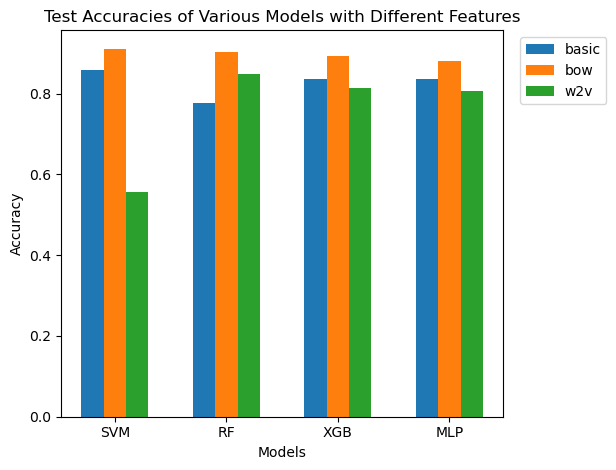

In [50]:
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_accuracy = [
    [0.8592592592592593, 0.9111111111111111, 0.5555555555555556],  # SVM
    [0.7777777777777778, 0.9037037037037037, 0.8481481481481481],  # RF
    [0.837037037037037, 0.8925925925925926, 0.8148148148148148],   # XGB
    [0.837037037037037, 0.8814814814814815, 0.8074074074074075]    # MLP
]


n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [acc[i] for acc in all_accuracy], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Accuracies of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_accuracies.png')

plt.show()

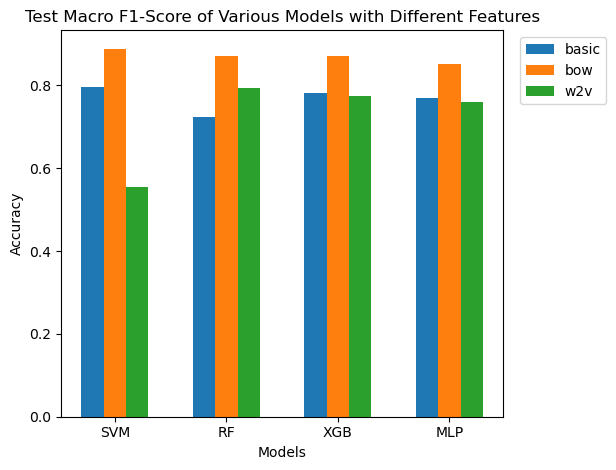

In [57]:
models = ['SVM', 'RF', 'XGB', 'MLP']
features = ['basic', 'bow', 'w2v']
all_f1 = [
    [0.7964285714285715, 0.8883066740209598, 0.554945054945055],  # SVM
    [0.7230769230769231, 0.8696524064171123, 0.7933892009929264], # RF
    [0.7816337034041615, 0.8697843042690127, 0.7746394230769231], # XGB
    [0.769696029776675, 0.8523076923076922, 0.76]                 # MLP
]

n_models = len(models)
n_features = len(features)

bar_width = 0.2
index = np.arange(n_models)

fig, ax = plt.subplots()

for i in range(n_features):
    plt.bar(index + i * bar_width, [f1[i] for f1 in all_f1], bar_width, label=features[i])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Test Macro F1-Score of Various Models with Different Features')
plt.xticks(index + bar_width * (n_features - 1) / 2, models)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

plt.tight_layout() 
plt.savefig('test_f1.png')

plt.show()

In [55]:
models = ['svc', 'rf', 'xgb', 'mlp']
print("Train Time: On Basic, BOW, and W2V")
for m in models:
    print(m)
    print(train_time_data[m])
print("Prediction Time: On Basic, BOW, and W2V")
for m in models:
    print(m)
    print(pred_time_data[m])

Train Time: On Basic, BOW, and W2V
svc
[0.031121015548706055, 0.6041316986083984, 0.5423200130462646]
rf
[0.06961703300476074, 0.07062888145446777, 0.2856569290161133]
xgb
[0.04040718078613281, 0.2539091110229492, 0.2082839012145996]
mlp
[0.1407480239868164, 6.278486013412476, 4.254907131195068]
Prediction Time: On Basic, BOW, and W2V
svc
[0.005435943603515625, 0.13843297958374023, 0.005554914474487305]
rf
[0.004568815231323242, 0.0032608509063720703, 0.003186941146850586]
xgb
[0.0023610591888427734, 0.0029501914978027344, 0.0020558834075927734]
mlp
[0.005695819854736328, 0.0056819915771484375, 0.00482487678527832]
